<a href="https://colab.research.google.com/github/sheldonkemper/bank_of_england/blob/main/notebooks/cleansed/kk_eda_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
===================================================
Author: Kasia Kirby
Role: Reporting Lead, Bank of England Employer Project (Quant Collective)
LinkedIn: https://www.linkedin.com/in/kasia-kirby
Date: 2025-03-04
Version: 2.0

Description:
    This notebook conducts descriptive analysis on the preprocessed earnings calls transcript data
    to understand its characteristics (e.g., text length, word frequency)
    and generate visualisations (word clouds, histograms) to highlight trends or anomalies.
    Data analysis run on two banks data: JPM and UBS transcripts from 2023-2024.

===================================================
"""

'\n===================================================\nAuthor: Kasia Kirby\nRole: Reporting Lead, Bank of England Employer Project (Quant Collective)\nLinkedIn: https://www.linkedin.com/in/kasia-kirby\nDate: 2025-03-04\nVersion: 2.0\n\nDescription:\n    This notebook conducts descriptive analysis on the preprocessed earnings calls transcript data\n    to understand its characteristics (e.g., text length, word frequency)\n    and generate visualisations (word clouds, histograms) to highlight trends or anomalies.\n    Data analysis run on two banks data: JPM and UBS transcripts from 2023-2024.\n\n===================================================\n'

# 0. Summarised, actionable findings based on EDA performed below

**Key Findings from EDA (JP Morgan & UBS) – Informing Topic & Sentiment Modelling**

- **Q&A Length & Executive Engagement**: JP Morgan’s **CFO dominates discussions**, while UBS shows **broader executive participation**, particularly from the CEO. **UBS answers tend to be shorter and more volatile**, while JP Morgan’s responses are longer and more stable.

- **Management Discussion Sentiment Discrepancies**: JP Morgan’s **management discussion sentiment is artificially inflated (~1.0 constant)**, making it unreliable for sentiment analysis. UBS management sentiment fluctuates more, making it a **stronger candidate for sentiment modelling**.

- **Sentiment vs. Executive Word Count**: **UBS CFO contributions spike when sentiment drops**, suggesting a **defensive communication strategy**, whereas JP Morgan’s sentiment trends are **less tied to word count changes**.

- **Key Topic Differentiation**: UBS discussions emphasize **Credit Suisse integration, balance sheet strength, and new money flows**, while JP Morgan focuses on **loan growth, private credit, and net interest income (NII)**. These differences should be **captured in topic modelling**.

- **Quarterly Sentiment Shifts: UBS shows greater sentiment volatility** than JP Morgan, with clear sentiment drops in **2Q24 and 4Q23**, possibly linked to financial uncertainty or market conditions.

- **Analyst Questions vs. Sentiment: UBS analyst questions show higher sentiment than JP Morgan’s**, suggesting **a more optimistic or constructive analyst tone**, which may influence executive responses.

- **Speaker Trends Over Time:** JP Morgan’s **CFO engagement is consistently high**, whereas UBS executives **show varied engagement levels**, possibly reflecting shifting leadership priorities.

- **Potential Risk Indicators: CFO-led discussions during sentiment dips** (particularly at UBS) may indicate **periods of financial concern**, making this an area worth tracking in future **risk-based topic modelling**.

These findings will help guide topic clustering for key themes and sentiment refinement, ensuring that differences in executive messaging, analyst tone, and sentiment patterns are well captured.


# 1. Import libraries and files

In [2]:
!pip install nltk > /dev/null 2>&1

In [3]:
import os
import sys
from google.colab import drive

import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from itertools import islice
from nltk.util import ngrams
from wordcloud import WordCloud
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

In [4]:
# Mount Google Drive to the root location
drive.mount('/content/drive', force_remount=True)
BOE_path = '/content/drive/MyDrive/BOE/bank_of_england/data/preprocessed_data'
# print(os.listdir(BOE_path))

Mounted at /content/drive


In [6]:
# Load JPM and UBS preprocessed transcripts

bank_files = {
    "JP Morgan Q&A": "jp_morgan_qna.csv",
    "JP Morgan Management": "jpmorgan_management_discussion.csv",
    "UBS Q&A": "ubs_qa_df_preprocessed_ver2.csv",
    "UBS Management": "ubs_management_discussion.csv"
}

for bank, file in bank_files.items():
    file_path = os.path.join(BOE_path, file)

    try:
        df = pd.read_csv(file_path, nrows=5)
        # print(f"\n **File: {file} ({bank})**")
        # print(df.columns.tolist())

    except Exception as e:
        print(f"\n⚠️ Could not read {file} ({bank}): {e}")

Steps below are to help us
- **assess data quality**
- **understand text characteristics**
- **identify anomalies before further analysis**

# 2. Analyse data structure & text length

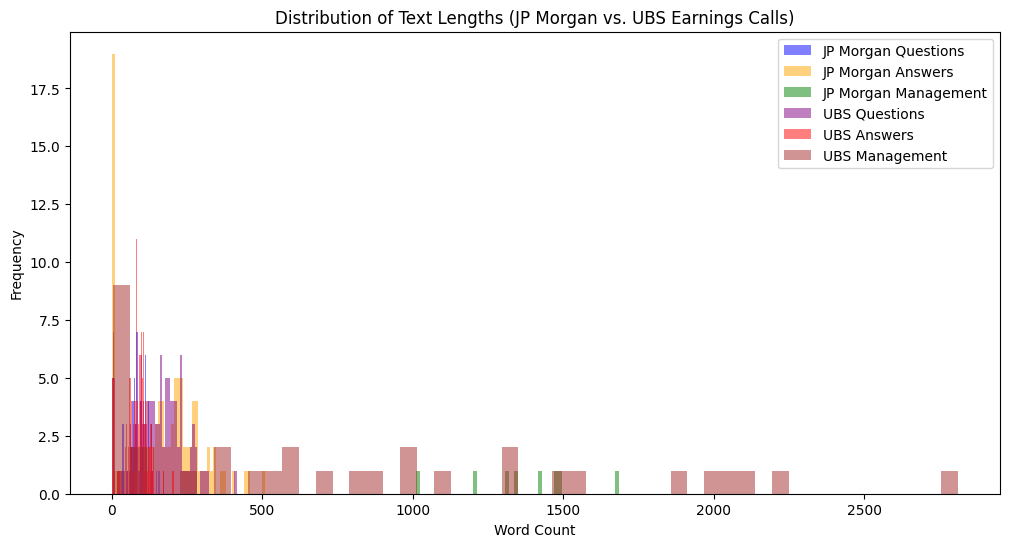

In [7]:
# Check missing values, text length distribution, and compare response length trends

jp_qna_df = pd.read_csv(f"{BOE_path}/jp_morgan_qna.csv")
jp_mgmt_df = pd.read_csv(f"{BOE_path}/jpmorgan_management_discussion.csv")
ubs_qna_df = pd.read_csv(f"{BOE_path}/ubs_qa_df_preprocessed_ver2.csv")
ubs_mgmt_df = pd.read_csv(f"{BOE_path}/ubs_management_discussion.csv")

# check for missing values
# print(" Missing Values in JP Morgan Q&A Data:\n", jp_qna_df.isnull().sum())
# print("\n Missing Values in JP Morgan Management Discussion Data:\n", jp_mgmt_df.isnull().sum())
# print("\n Missing Values in UBS Q&A Data:\n", ubs_qna_df.isnull().sum())
# print("\n Missing Values in UBS Management Discussion Data:\n", ubs_mgmt_df.isnull().sum())

# compute word counts for Q&A
jp_qna_df["question_word_count"] = jp_qna_df["Question_cleaned"].astype(str).apply(lambda x: len(x.split()))
jp_qna_df["answer_word_count"] = jp_qna_df["Response_cleaned"].astype(str).apply(lambda x: len(x.split()))
ubs_qna_df["question_word_count"] = ubs_qna_df["Question_cleaned"].astype(str).apply(lambda x: len(x.split()))
ubs_qna_df["answer_word_count"] = ubs_qna_df["Response_cleaned"].astype(str).apply(lambda x: len(x.split()))

# compute word counts for management discussion
jp_mgmt_df["text_word_count"] = jp_mgmt_df["Utterance_cleaned"].astype(str).apply(lambda x: len(x.split()))
ubs_mgmt_df["text_word_count"] = ubs_mgmt_df["Utterance_cleaned"].astype(str).apply(lambda x: len(x.split()))

# plot word count distribution for both banks
plt.figure(figsize=(12, 6))
plt.hist(jp_qna_df["question_word_count"], bins=50, alpha=0.5, label="JP Morgan Questions", color='blue')
plt.hist(jp_qna_df["answer_word_count"], bins=50, alpha=0.5, label="JP Morgan Answers", color='orange')
plt.hist(jp_mgmt_df["text_word_count"], bins=50, alpha=0.5, label="JP Morgan Management", color='green')

plt.hist(ubs_qna_df["question_word_count"], bins=50, alpha=0.5, label="UBS Questions", color='purple', linestyle="dashed")
plt.hist(ubs_qna_df["answer_word_count"], bins=50, alpha=0.5, label="UBS Answers", color='red', linestyle="dashed")
plt.hist(ubs_mgmt_df["text_word_count"], bins=50, alpha=0.5, label="UBS Management", color='brown', linestyle="dashed")

plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Distribution of Text Lengths (JP Morgan vs. UBS Earnings Calls)")
plt.legend()
plt.show()

# summary statistics
# print("\n Summary Statistics:")
# print("\n JP Morgan Q&A Questions:\n", jp_qna_df["question_word_count"].describe())
# print("\n JP Morgan Q&A Answers:\n", jp_qna_df["answer_word_count"].describe())
# print("\n JP Morgan Management Discussion:\n", jp_mgmt_df["text_word_count"].describe())

# print("\n UBS Q&A Questions:\n", ubs_qna_df["question_word_count"].describe())
# print("\n UBS Q&A Answers:\n", ubs_qna_df["answer_word_count"].describe())
# print("\n UBS Management Discussion:\n", ubs_mgmt_df["text_word_count"].describe())

- 🔸 Some missing values are present for both banks, however as the text is already cleaned this may not be significant for further analysis.
- 💡 UBS questions are almost twice as long compared to JMP (avg. 164 vs 82 respectively), while JPM answers are much longer (avg.180 vs 85), suggesting that **UBS analysts ask more detailed questions while JPM executives provide more in-depth responses**.
- 🔸 High variability in UBS management discussion (std = 802) suggest that segmentation could be improved for better consistency.

Note: UBS's shorter answers may impact sentiment analysis - sentiment scoring may be more variable with brief responses.

In [8]:
# Print examples of short answers (fewer than 5 words)

jp_short_answers = jp_qna_df[jp_qna_df["answer_word_count"] < 5][["Response_cleaned", "Executive", "Quarter"]]
ubs_short_answers = ubs_qna_df[ubs_qna_df["answer_word_count"] < 5][["Response_cleaned", "Executive", "Quarter"]]

# print("Examples of Very Short Answers (JP Morgan):\n")
# print(jp_short_answers.head(10))

# print("\nExamples of Very Short Answers (UBS):\n")
# print(ubs_short_answers.head(10))


❗Exclude meaningless short responses ("questions," "nan") from topic modelling, as they do not contain informative content.

❗1Q23 has many missing responses - this quarter should be repopulated with original data or excluded from analysis.

# 3. Get word frequency & key themes

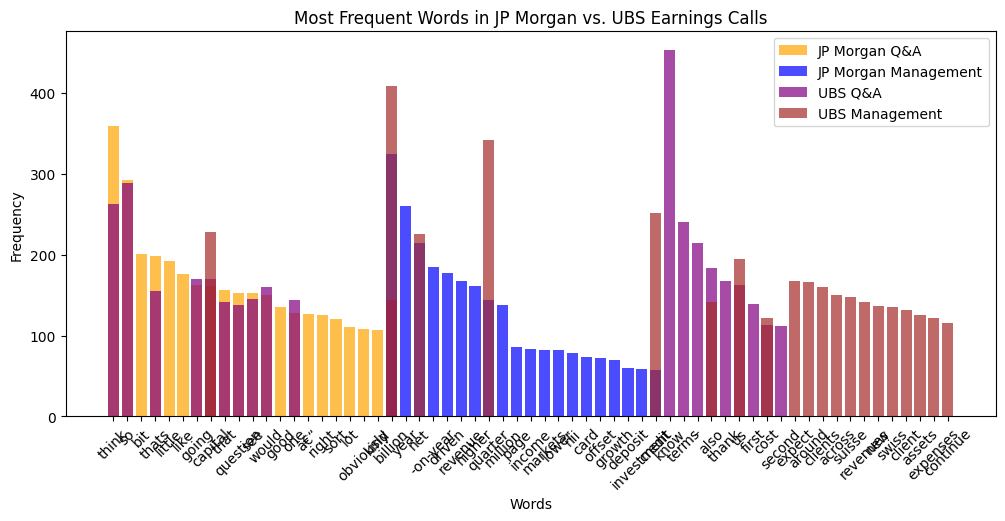

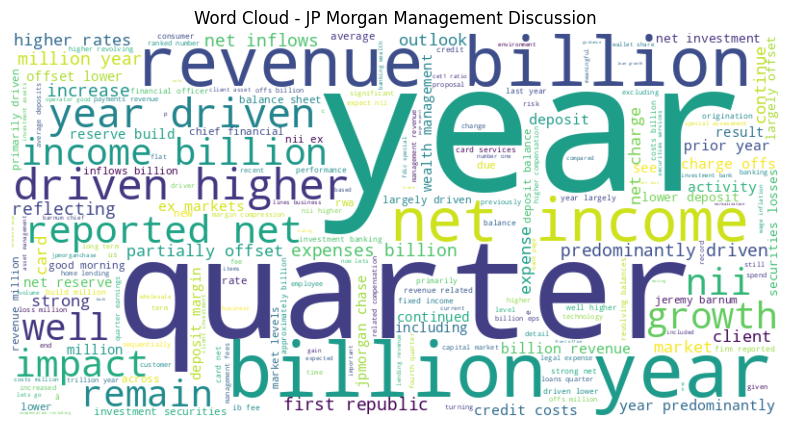

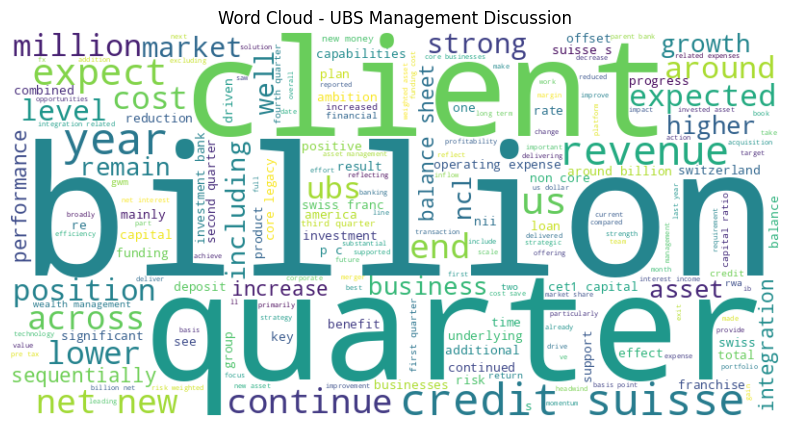

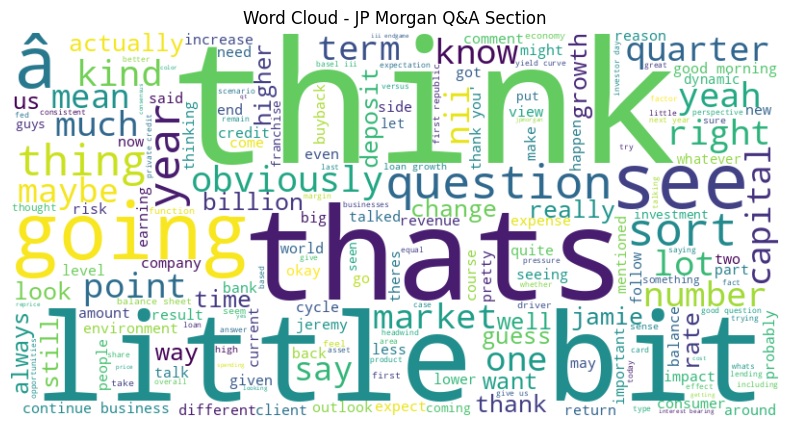

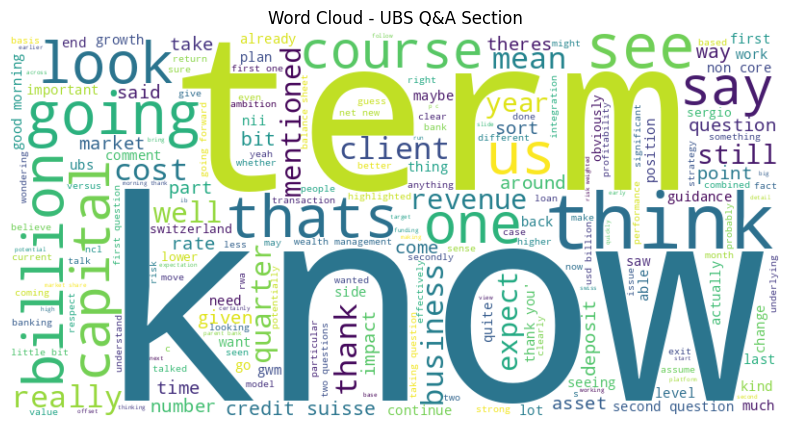


Top Bigrams in JP Morgan Q&A:
 [(('little', 'bit'), 166), (('good', 'morning'), 43), (('thank', "you']"), 42), (('so', 'think'), 31), (('loan', 'growth'), 29), (('first', 'republic'), 27), (('basel', 'iii'), 26), (('investor', 'day'), 25), (('yield', 'curve'), 25), (('good', 'question'), 24), (('balance', 'sheet'), 23), (('got', 'it'), 23), (('private', 'credit'), 22), (('give', 'us'), 22), (('else', 'equal'), 22)]

Top Bigrams in JP Morgan Management Discussion:
 [(('year', '-on-year'), 185), (('net', 'income'), 61), (('driven', 'higher'), 60), (('reported', 'net'), 46), (('-on-year', 'driven'), 42), (('predominantly', 'driven'), 37), (('net', 'inflows'), 37), (('first', 'republic'), 37), (('partially', 'offset'), 32), (('higher', 'rates'), 31), (('net', 'charge'), 30), (('billion', 'revenue'), 28), (('credit', 'costs'), 27), (('ex', 'markets'), 26), (('quarter', '-on-quarter'), 25)]

Top Trigrams in JP Morgan Q&A:
 [(('basel', 'iii', 'endgame'), 21), (("['hi", 'good', 'morning'), 18

In [9]:
# Extract most common words, frequent financial phrases, compare Q&A and management topics

jp_qna_df = pd.read_csv(f"{BOE_path}/jp_morgan_qna.csv")
jp_mgmt_df = pd.read_csv(f"{BOE_path}/jpmorgan_management_discussion.csv")
ubs_qna_df = pd.read_csv(f"{BOE_path}/ubs_qa_df_preprocessed_ver2.csv")
ubs_mgmt_df = pd.read_csv(f"{BOE_path}/ubs_management_discussion.csv")

# concatenate text for analysis (ensuring non-null values)
jp_qna_text = ' '.join(jp_qna_df["Question_cleaned"].dropna()) + ' ' + ' '.join(jp_qna_df["Response_cleaned"].dropna())
jp_mgmt_text = ' '.join(jp_mgmt_df["Utterance_cleaned"].dropna())

ubs_qna_text = ' '.join(ubs_qna_df["Question_cleaned"].dropna()) + ' ' + ' '.join(ubs_qna_df["Response_cleaned"].dropna())
ubs_mgmt_text = ' '.join(ubs_mgmt_df["Utterance_cleaned"].dropna())

# function to get most common words
def get_most_common_words(text, top_n=20):
    words = text.split()
    word_freq = Counter(words)
    return word_freq.most_common(top_n)

# function to generate and count n-grams
def get_most_common_ngrams(text, n=2, top_n=15):
    words = text.split()
    ngram_list = list(ngrams(words, n))
    ngram_freq = Counter(ngram_list)
    return ngram_freq.most_common(top_n)

# get word frequencies
jp_top_words_qna = get_most_common_words(jp_qna_text)
jp_top_words_mgmt = get_most_common_words(jp_mgmt_text)
ubs_top_words_qna = get_most_common_words(ubs_qna_text)
ubs_top_words_mgmt = get_most_common_words(ubs_mgmt_text)

# get bigrams & trigrams
jp_top_bigrams_qna = get_most_common_ngrams(jp_qna_text, n=2)
jp_top_bigrams_mgmt = get_most_common_ngrams(jp_mgmt_text, n=2)
jp_top_trigrams_qna = get_most_common_ngrams(jp_qna_text, n=3)
jp_top_trigrams_mgmt = get_most_common_ngrams(jp_mgmt_text, n=3)

ubs_top_bigrams_qna = get_most_common_ngrams(ubs_qna_text, n=2)
ubs_top_bigrams_mgmt = get_most_common_ngrams(ubs_mgmt_text, n=2)
ubs_top_trigrams_qna = get_most_common_ngrams(ubs_qna_text, n=3)
ubs_top_trigrams_mgmt = get_most_common_ngrams(ubs_mgmt_text, n=3)

# convert to DataFrame for visualization
jp_df_qna_words = pd.DataFrame(jp_top_words_qna, columns=['Word', 'Frequency'])
jp_df_mgmt_words = pd.DataFrame(jp_top_words_mgmt, columns=['Word', 'Frequency'])
ubs_df_qna_words = pd.DataFrame(ubs_top_words_qna, columns=['Word', 'Frequency'])
ubs_df_mgmt_words = pd.DataFrame(ubs_top_words_mgmt, columns=['Word', 'Frequency'])

# plot most common words for both banks
plt.figure(figsize=(12, 5))
plt.bar(jp_df_qna_words['Word'], jp_df_qna_words['Frequency'], alpha=0.7, label='JP Morgan Q&A', color='orange')
plt.bar(jp_df_mgmt_words['Word'], jp_df_mgmt_words['Frequency'], alpha=0.7, label='JP Morgan Management', color='blue')
plt.bar(ubs_df_qna_words['Word'], ubs_df_qna_words['Frequency'], alpha=0.7, label='UBS Q&A', color='purple')
plt.bar(ubs_df_mgmt_words['Word'], ubs_df_mgmt_words['Frequency'], alpha=0.7, label='UBS Management', color='brown')
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most Frequent Words in JP Morgan vs. UBS Earnings Calls")
plt.legend()
plt.show()

# word clouds for management discussion (both banks)
wordcloud_jp_mgmt = WordCloud(width=800, height=400, background_color='white').generate(jp_mgmt_text)
wordcloud_ubs_mgmt = WordCloud(width=800, height=400, background_color='white').generate(ubs_mgmt_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_jp_mgmt, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - JP Morgan Management Discussion")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_ubs_mgmt, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - UBS Management Discussion")
plt.show()

# word clouds for Q&A section (both banks)
wordcloud_jp_qa = WordCloud(width=800, height=400, background_color='white').generate(jp_qna_text)
wordcloud_ubs_qa = WordCloud(width=800, height=400, background_color='white').generate(ubs_qna_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_jp_qa, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - JP Morgan Q&A Section")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_ubs_qa, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - UBS Q&A Section")
plt.show()

# print top bigrams & trigrams for both banks
print("\nTop Bigrams in JP Morgan Q&A:\n", jp_top_bigrams_qna)
print("\nTop Bigrams in JP Morgan Management Discussion:\n", jp_top_bigrams_mgmt)
print("\nTop Trigrams in JP Morgan Q&A:\n", jp_top_trigrams_qna)
print("\nTop Trigrams in JP Morgan Management Discussion:\n", jp_top_trigrams_mgmt)

print("\nTop Bigrams in UBS Q&A:\n", ubs_top_bigrams_qna)
print("\nTop Bigrams in UBS Management Discussion:\n", ubs_top_bigrams_mgmt)
print("\nTop Trigrams in UBS Q&A:\n", ubs_top_trigrams_qna)
print("\nTop Trigrams in UBS Management Discussion:\n", ubs_top_trigrams_mgmt)

- **JP Morgan’s Q&A emphasizes market conditions** ("loan growth," "yield curve"), regulatory concerns ("Basel III endgame"), and investment strategy ("private credit," "investor day"). **UBS Q&A, in contrast, is acquisition-focused**, with key phrases like "credit suisse," "net new money," and "capital ratio," reflecting investor concerns on post-merger integration.

- Management discussions also diverge: JP Morgan highlights performance metrics** ("net income," "revenue growth," "year-on-year"), while UBS centers on balance sheet restructuring and capital positioning ("credit suisse acquisition," "operating expenses," "capital ratio").

- JP Morgan’s language is conversational, frequently using filler phrases ("little bit," "thank you"), whereas UBS executives use more precise financial terminology. This suggests **JP Morgan’s discussions are more market-oriented, while UBS’s are restructuring-focused**.

- 💡 For topic modeling, BERTopic should separate UBS’s post-acquisition themes from financial performance, while for JP Morgan, investment strategy and regulatory discussions should be distinct.

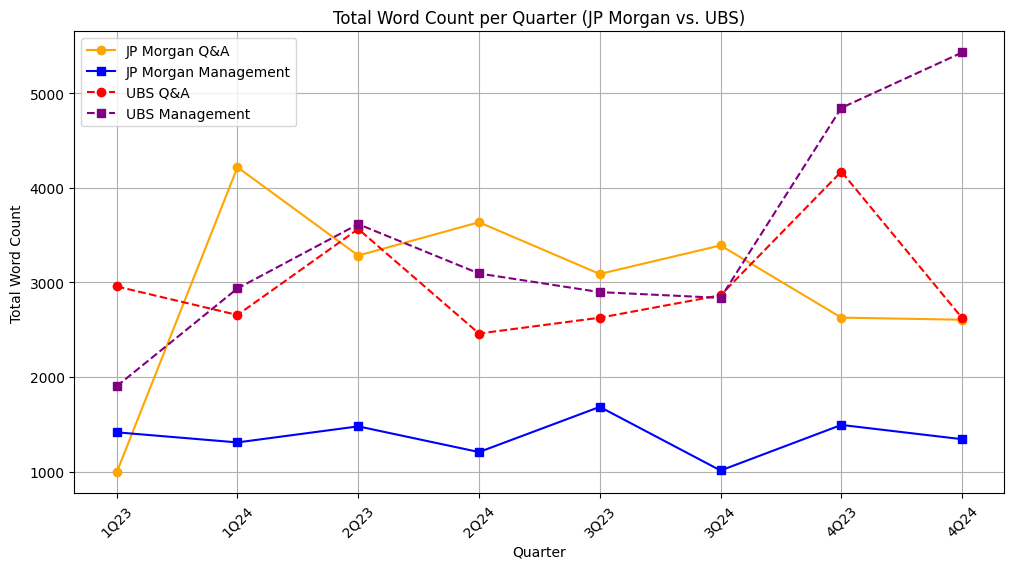

In [10]:
# Check word count per quarter (Q&A and Management)

jp_qna_df = pd.read_csv(f"{BOE_path}/jp_morgan_qna.csv")
jp_management_df = pd.read_csv(f"{BOE_path}/jpmorgan_management_discussion.csv")
ubs_qna_df = pd.read_csv(f"{BOE_path}/ubs_qa_df_preprocessed_ver2.csv")
ubs_management_df = pd.read_csv(f"{BOE_path}/ubs_management_discussion.csv")

# compute total word count
jp_qna_df["qna_word_count"] = jp_qna_df["Question_cleaned"].astype(str).apply(lambda x: len(x.split())) + \
                              jp_qna_df["Response_cleaned"].astype(str).apply(lambda x: len(x.split()))
jp_management_df["text_word_count"] = jp_management_df["Utterance_cleaned"].astype(str).apply(lambda x: len(x.split()))

ubs_qna_df["qna_word_count"] = ubs_qna_df["Question_cleaned"].astype(str).apply(lambda x: len(x.split())) + \
                               ubs_qna_df["Response_cleaned"].astype(str).apply(lambda x: len(x.split()))
ubs_management_df["text_word_count"] = ubs_management_df["Utterance_cleaned"].astype(str).apply(lambda x: len(x.split()))

# aggregate total word count per quarter
jp_qna_word_count = jp_qna_df.groupby("Quarter")["qna_word_count"].sum().reset_index()
jp_management_word_count = jp_management_df.groupby("Quarter")["text_word_count"].sum().reset_index()

ubs_qna_word_count = ubs_qna_df.groupby("Quarter")["qna_word_count"].sum().reset_index()
ubs_management_word_count = ubs_management_df.groupby("Quarter")["text_word_count"].sum().reset_index()

# plot word count trends over time
plt.figure(figsize=(12, 6))
plt.plot(jp_qna_word_count["Quarter"], jp_qna_word_count["qna_word_count"], marker="o", label="JP Morgan Q&A", color="orange")
plt.plot(jp_management_word_count["Quarter"], jp_management_word_count["text_word_count"], marker="s", label="JP Morgan Management", color="blue")
plt.plot(ubs_qna_word_count["Quarter"], ubs_qna_word_count["qna_word_count"], marker="o", linestyle="dashed", label="UBS Q&A", color="red")
plt.plot(ubs_management_word_count["Quarter"], ubs_management_word_count["text_word_count"], marker="s", linestyle="dashed", label="UBS Management", color="purple")

plt.xlabel("Quarter")
plt.ylabel("Total Word Count")
plt.title("Total Word Count per Quarter (JP Morgan vs. UBS)")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

- **JP Morgan’s engagement model is Q&A-driven, whereas UBS increasingly leans on Management Discussion** (JPM Q&A sections are significantly longer than management discussions, while UBS management discussions increase over time and surpass Q&A sections most of the time.)
- UBS’s Management Discussion sees a late surge (4Q23-4Q24), contrasting with JP Morgan’s relatively stable executive-led content. This is primarily attributed to UBS acquisition of Credit Suisse.

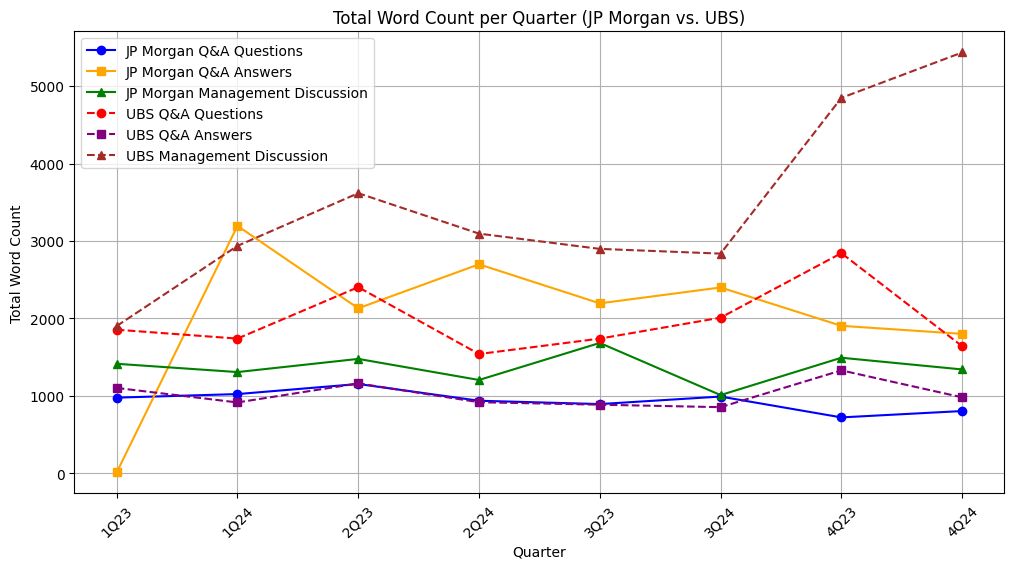

In [11]:
# Check word count per quarter (Questions, Answers, Management)

jp_qna_df = pd.read_csv(f"{BOE_path}/jp_morgan_qna.csv")
jp_management_df = pd.read_csv(f"{BOE_path}/jpmorgan_management_discussion.csv")
ubs_qna_df = pd.read_csv(f"{BOE_path}/ubs_qa_df_preprocessed_ver2.csv")
ubs_management_df = pd.read_csv(f"{BOE_path}/ubs_management_discussion.csv")

# compute word count for each section
jp_qna_df["question_word_count"] = jp_qna_df["Question_cleaned"].astype(str).apply(lambda x: len(x.split()))
jp_qna_df["answer_word_count"] = jp_qna_df["Response_cleaned"].astype(str).apply(lambda x: len(x.split()))
jp_management_df["text_word_count"] = jp_management_df["Utterance_cleaned"].astype(str).apply(lambda x: len(x.split()))

ubs_qna_df["question_word_count"] = ubs_qna_df["Question_cleaned"].astype(str).apply(lambda x: len(x.split()))
ubs_qna_df["answer_word_count"] = ubs_qna_df["Response_cleaned"].astype(str).apply(lambda x: len(x.split()))
ubs_management_df["text_word_count"] = ubs_management_df["Utterance_cleaned"].astype(str).apply(lambda x: len(x.split()))

# aggregate word count per quarter
jp_qna_word_count = jp_qna_df.groupby("Quarter")[["question_word_count", "answer_word_count"]].sum().reset_index()
jp_management_word_count = jp_management_df.groupby("Quarter")[["text_word_count"]].sum().reset_index()

ubs_qna_word_count = ubs_qna_df.groupby("Quarter")[["question_word_count", "answer_word_count"]].sum().reset_index()
ubs_management_word_count = ubs_management_df.groupby("Quarter")[["text_word_count"]].sum().reset_index()

# plot word count trends over time
plt.figure(figsize=(12, 6))
plt.plot(jp_qna_word_count["Quarter"], jp_qna_word_count["question_word_count"], marker="o", label="JP Morgan Q&A Questions", color="blue")
plt.plot(jp_qna_word_count["Quarter"], jp_qna_word_count["answer_word_count"], marker="s", label="JP Morgan Q&A Answers", color="orange")
plt.plot(jp_management_word_count["Quarter"], jp_management_word_count["text_word_count"], marker="^", label="JP Morgan Management Discussion", color="green")

plt.plot(ubs_qna_word_count["Quarter"], ubs_qna_word_count["question_word_count"], marker="o", linestyle="dashed", label="UBS Q&A Questions", color="red")
plt.plot(ubs_qna_word_count["Quarter"], ubs_qna_word_count["answer_word_count"], marker="s", linestyle="dashed", label="UBS Q&A Answers", color="purple")
plt.plot(ubs_management_word_count["Quarter"], ubs_management_word_count["text_word_count"], marker="^", linestyle="dashed", label="UBS Management Discussion", color="brown")

plt.xlabel("Quarter")
plt.ylabel("Total Word Count")
plt.title("Total Word Count per Quarter (JP Morgan vs. UBS)")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Breaking down JPM Q&A into questions vs. answers reveals that answers are the primary driver of word count spikes rather than an increase in questions, **suggesting JPM executives elaborated more in certain quarters rather than analysts asking more**.
For UBS, the pattern is slightly different. While UBS executives also provide longer responses, the gap between question and answer word counts is narrower in some quarters compared to JP Morgan. This suggests that **UBS analysts may be engaging in more detailed questioning, rather than just executives elaborating more**. Additionally, UBS Q&A exhibits greater volatility, whereas JP Morgan's pattern is more consistent across quarters.

# 4. Sentiment readiness check

Check for positive/negative words present, any potential biases in wording, check for extreme sentiment shifts (anomalies)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


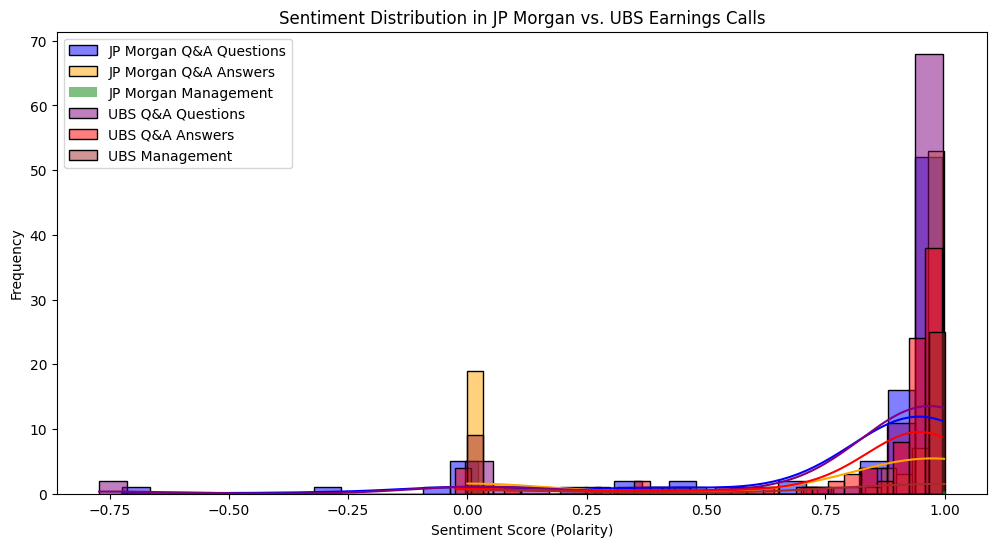

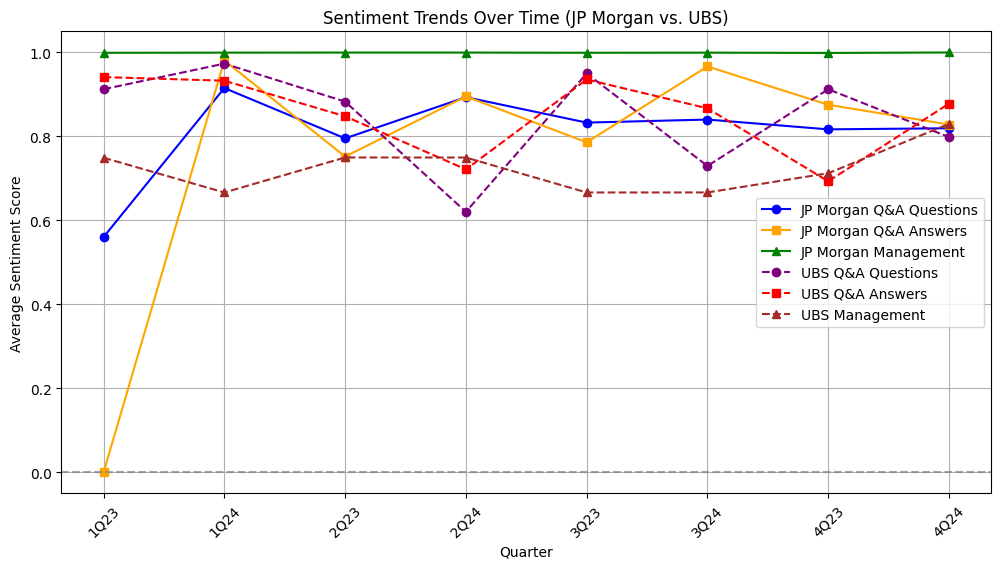


Sentiment Summary Statistics (JP Morgan):
Q&A Questions: count    91.000000
mean      0.805635
std       0.339251
min      -0.723400
25%       0.883250
50%       0.950000
75%       0.973800
max       0.995300
Name: question_sentiment, dtype: float64
Q&A Answers: count    91.000000
mean      0.748988
std       0.401932
min       0.000000
25%       0.794600
50%       0.976400
75%       0.992250
max       0.998900
Name: answer_sentiment, dtype: float64
Management Discussion: count    8.000000
mean     0.999125
std      0.000365
min      0.998500
25%      0.998875
50%      0.999200
75%      0.999400
max      0.999600
Name: text_sentiment, dtype: float64

Sentiment Summary Statistics (UBS):
Q&A Questions: count    96.000000
mean      0.844891
std       0.348417
min      -0.771700
25%       0.926300
50%       0.977750
75%       0.990050
max       0.997100
Name: question_sentiment, dtype: float64
Q&A Answers: count    96.000000
mean      0.840080
std       0.260181
min      -0.025800
25%    

In [12]:
# Compute sentiment scores and distribution (using Vader)

nltk.download('vader_lexicon')

jp_qna_df = pd.read_csv(f"{BOE_path}/jp_morgan_qna.csv")
jp_management_df = pd.read_csv(f"{BOE_path}/jpmorgan_management_discussion.csv")
ubs_qna_df = pd.read_csv(f"{BOE_path}/ubs_qa_df_preprocessed_ver2.csv")
ubs_management_df = pd.read_csv(f"{BOE_path}/ubs_management_discussion.csv")

sia = SentimentIntensityAnalyzer()

# compute sentiment scores and apply sentiment analysis
def get_sentiment(text):
    if isinstance(text, str):
        return sia.polarity_scores(text)["compound"]
    return None

jp_qna_df["question_sentiment"] = jp_qna_df["Question_cleaned"].apply(get_sentiment)
jp_qna_df["answer_sentiment"] = jp_qna_df["Response_cleaned"].apply(get_sentiment)
jp_management_df["text_sentiment"] = jp_management_df["Utterance_cleaned"].apply(get_sentiment)

ubs_qna_df["question_sentiment"] = ubs_qna_df["Question_cleaned"].apply(get_sentiment)
ubs_qna_df["answer_sentiment"] = ubs_qna_df["Response_cleaned"].apply(get_sentiment)
ubs_management_df["text_sentiment"] = ubs_management_df["Utterance_cleaned"].apply(get_sentiment)

# plot sentiment distribution
plt.figure(figsize=(12, 6))
sns.histplot(jp_qna_df["question_sentiment"], bins=30, kde=True, label="JP Morgan Q&A Questions", color="blue", alpha=0.5)
sns.histplot(jp_qna_df["answer_sentiment"], bins=30, kde=True, label="JP Morgan Q&A Answers", color="orange", alpha=0.5)
sns.histplot(jp_management_df["text_sentiment"], bins=30, kde=True, label="JP Morgan Management", color="green", alpha=0.5)

sns.histplot(ubs_qna_df["question_sentiment"], bins=30, kde=True, label="UBS Q&A Questions", color="purple", alpha=0.5)
sns.histplot(ubs_qna_df["answer_sentiment"], bins=30, kde=True, label="UBS Q&A Answers", color="red", alpha=0.5)
sns.histplot(ubs_management_df["text_sentiment"], bins=30, kde=True, label="UBS Management", color="brown", alpha=0.5)

plt.xlabel("Sentiment Score (Polarity)")
plt.ylabel("Frequency")
plt.title("Sentiment Distribution in JP Morgan vs. UBS Earnings Calls")
plt.legend()
plt.show()

# average sentiment per quarter
jp_qna_sentiment_by_quarter = jp_qna_df.groupby("Quarter")[["question_sentiment", "answer_sentiment"]].mean()
jp_management_sentiment_by_quarter = jp_management_df.groupby("Quarter")[["text_sentiment"]].mean()

ubs_qna_sentiment_by_quarter = ubs_qna_df.groupby("Quarter")[["question_sentiment", "answer_sentiment"]].mean()
ubs_management_sentiment_by_quarter = ubs_management_df.groupby("Quarter")[["text_sentiment"]].mean()

# plot sentiment trends over time
plt.figure(figsize=(12, 6))
plt.plot(jp_qna_sentiment_by_quarter.index, jp_qna_sentiment_by_quarter["question_sentiment"], marker="o", label="JP Morgan Q&A Questions", color="blue")
plt.plot(jp_qna_sentiment_by_quarter.index, jp_qna_sentiment_by_quarter["answer_sentiment"], marker="s", label="JP Morgan Q&A Answers", color="orange")
plt.plot(jp_management_sentiment_by_quarter.index, jp_management_sentiment_by_quarter["text_sentiment"], marker="^", label="JP Morgan Management", color="green")

plt.plot(ubs_qna_sentiment_by_quarter.index, ubs_qna_sentiment_by_quarter["question_sentiment"], marker="o", linestyle="dashed", label="UBS Q&A Questions", color="purple")
plt.plot(ubs_qna_sentiment_by_quarter.index, ubs_qna_sentiment_by_quarter["answer_sentiment"], marker="s", linestyle="dashed", label="UBS Q&A Answers", color="red")
plt.plot(ubs_management_sentiment_by_quarter.index, ubs_management_sentiment_by_quarter["text_sentiment"], marker="^", linestyle="dashed", label="UBS Management", color="brown")

plt.axhline(0, linestyle="--", color="gray", alpha=0.7)
plt.xlabel("Quarter")
plt.ylabel("Average Sentiment Score")
plt.title("Sentiment Trends Over Time (JP Morgan vs. UBS)")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

# sentiment summary statistics
print("\nSentiment Summary Statistics (JP Morgan):")
print("Q&A Questions:", jp_qna_df["question_sentiment"].describe())
print("Q&A Answers:", jp_qna_df["answer_sentiment"].describe())
print("Management Discussion:", jp_management_df["text_sentiment"].describe())

print("\nSentiment Summary Statistics (UBS):")
print("Q&A Questions:", ubs_qna_df["question_sentiment"].describe())
print("Q&A Answers:", ubs_qna_df["answer_sentiment"].describe())
print("Management Discussion:", ubs_management_df["text_sentiment"].describe())

**JPM**

- The **sentiment of JP Morgan’s Q&A is overall positive**, with questions averaging 0.81 and answers averaging 0.75, though answers show greater variability (std = 0.40).
- The sentiment trend is **relatively stable** across quarters, though Q&A answers exhibit greater fluctuations than questions, reflecting variability in executive tone rather than analyst sentiment.
- **Management Discussion shows an overwhelmingly positive sentiment** (near 1.0), with almost no variation reinforcing previous concerns that this dataset may be artificially inflated, limiting its utility for deeper sentiment analysis. Q&A sentiment is more balanced, with both positive and negative sentiment present, indicating greater emotional variation in analyst-executive interactions.

**UBS**

- UBS Q&A maintains a **higher sentiment score than JP Morgan**, with questions averaging 0.84 and answers 0.84, showing less variability (std = 0.26) compared to JP Morgan.
- UBS's sentiment exhibits **greater declines in specific quarters**, particularly in **Q4 2023 and Q2 2024**, potentially signaling shifts in executive outlook or external market conditions.
- Management Discussion: **UBS Management sentiment is significantly lower** (0.73 avg) and more variable than JP Morgan, suggesting it contains **more realistic sentiment fluctuations** and may be a more valuable input for modeling.

💡 Overall, UBS Q&A sentiment is more stable than JP Morgan’s, with higher scores and less variance, indicating less emotional or defensive executive responses. JP Morgan’s management sentiment is likely inflated, while UBS’s is more dynamic, making it more informative for sentiment-driven analysis.
Further validation with more complex models is needed to ensure sentiment robustness, particularly for management discussion where JP Morgan’s extreme positivity could distort results.

# 5. Speaker & Role-Based Analysis (Q&A only)




Who drives discussions, how does engagement vary per role, trends over time

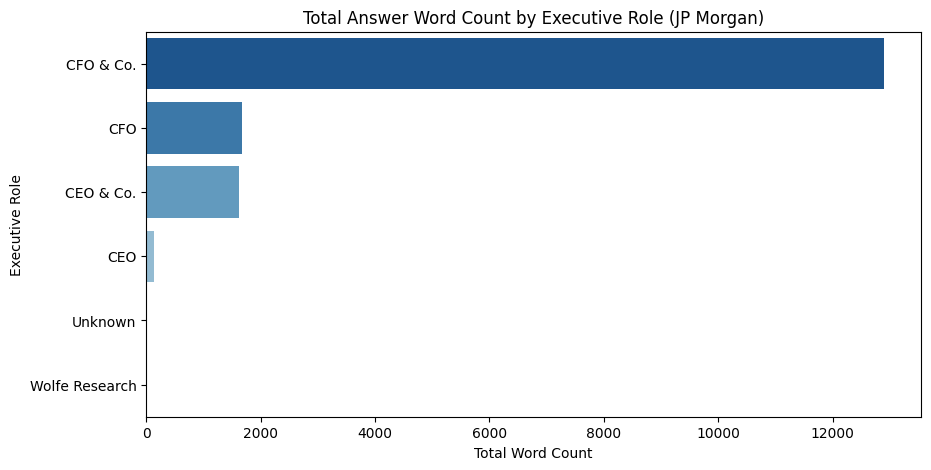

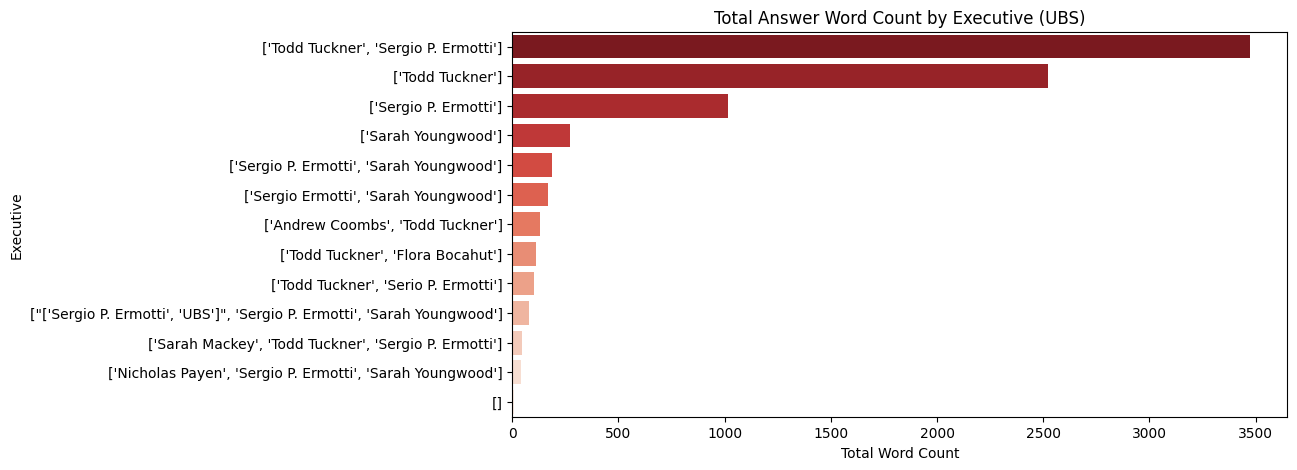

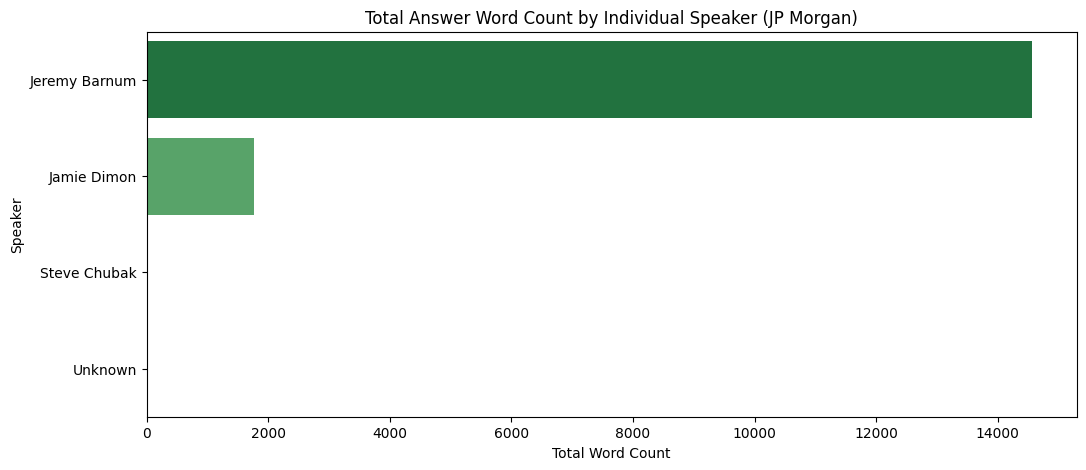

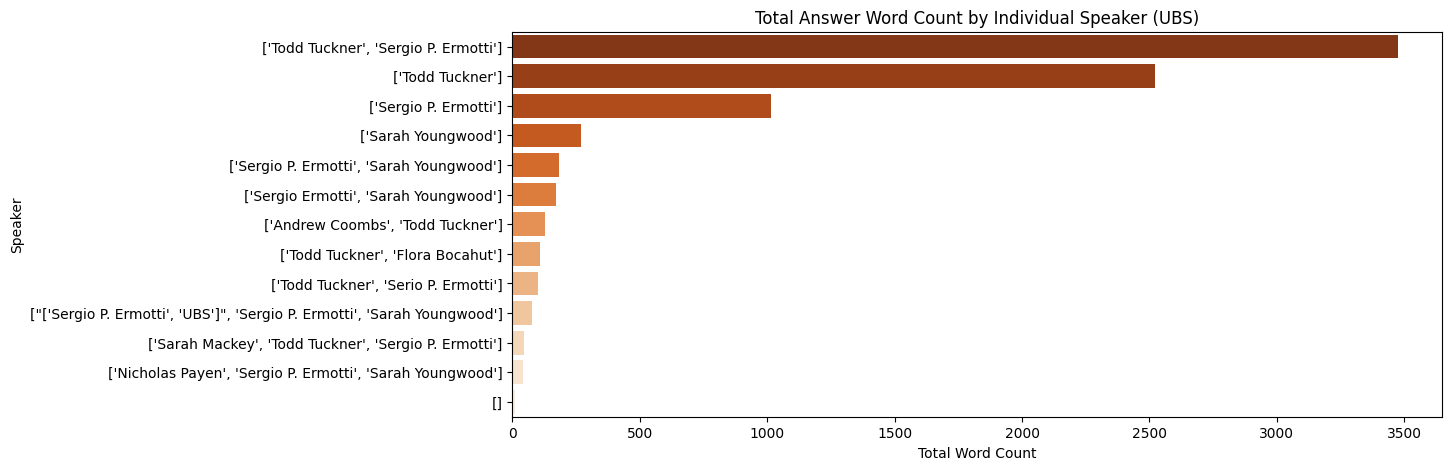

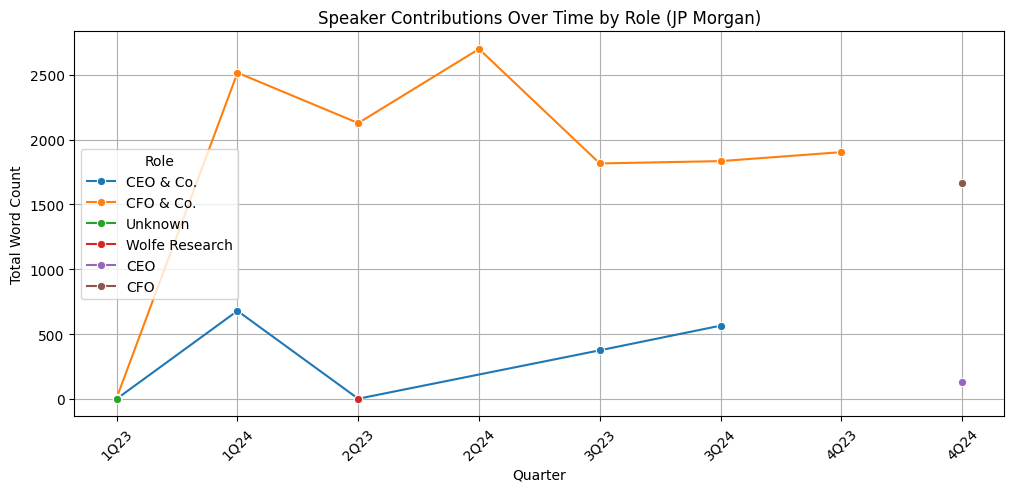

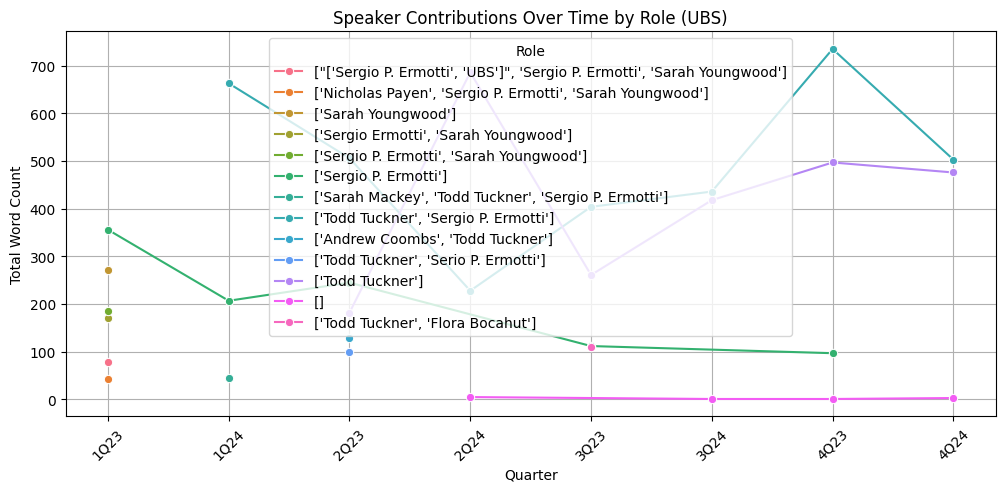

In [13]:
# Compare word count by speaker role

jp_qna_df = pd.read_csv(f"{BOE_path}/jp_morgan_qna.csv")
ubs_qna_df = pd.read_csv(f"{BOE_path}/ubs_qa_df_preprocessed_ver2.csv")

# word counts for JPMorgan
jp_qna_df["answer_word_count"] = jp_qna_df["Response_cleaned"].astype(str).apply(lambda x: len(x.split()))
jp_role_word_count = jp_qna_df.groupby("Executive Role Type")["answer_word_count"].sum().reset_index()
jp_role_word_count = jp_role_word_count.sort_values(by="answer_word_count", ascending=False)

# word counts for UBS
ubs_qna_df["answer_word_count"] = ubs_qna_df["Response_cleaned"].astype(str).apply(lambda x: len(x.split()))
ubs_role_word_count = ubs_qna_df.groupby("Executive")["answer_word_count"].sum().reset_index()
ubs_role_word_count = ubs_role_word_count.sort_values(by="answer_word_count", ascending=False)

# plot JPMorgan roles
plt.figure(figsize=(10, 5))
sns.barplot(x="answer_word_count", y="Executive Role Type", data=jp_role_word_count, hue="Executive Role Type", palette="Blues_r", legend=False)
plt.xlabel("Total Word Count")
plt.ylabel("Executive Role")
plt.title("Total Answer Word Count by Executive Role (JP Morgan)")
plt.show()

# plot UBS roles
plt.figure(figsize=(10, 5))
sns.barplot(x="answer_word_count", y="Executive", data=ubs_role_word_count, hue="Executive", palette="Reds_r", legend=False)
plt.xlabel("Total Word Count")
plt.ylabel("Executive")
plt.title("Total Answer Word Count by Executive (UBS)")
plt.show()

# word count per speaker for JPMorgan
jp_speaker_word_count = jp_qna_df.groupby("Executive")["answer_word_count"].sum().reset_index()
jp_speaker_word_count = jp_speaker_word_count.sort_values(by="answer_word_count", ascending=False)

# word count per speaker for UBS
ubs_speaker_word_count = ubs_qna_df.groupby("Executive")["answer_word_count"].sum().reset_index()
ubs_speaker_word_count = ubs_speaker_word_count.sort_values(by="answer_word_count", ascending=False)

# plot JPMorgan speakers
plt.figure(figsize=(12, 5))
sns.barplot(x="answer_word_count", y="Executive", data=jp_speaker_word_count, hue="Executive", palette="Greens_r", legend=False)
plt.xlabel("Total Word Count")
plt.ylabel("Speaker")
plt.title("Total Answer Word Count by Individual Speaker (JP Morgan)")
plt.show()

# plot UBS speakers
plt.figure(figsize=(12, 5))
sns.barplot(x="answer_word_count", y="Executive", data=ubs_speaker_word_count, hue="Executive", palette="Oranges_r", legend=False)
plt.xlabel("Total Word Count")
plt.ylabel("Speaker")
plt.title("Total Answer Word Count by Individual Speaker (UBS)")
plt.show()

# speaker contributions over time
jp_role_trends = jp_qna_df.groupby(["Quarter", "Executive Role Type"])["answer_word_count"].sum().reset_index()
ubs_role_trends = ubs_qna_df.groupby(["Quarter", "Executive"])["answer_word_count"].sum().reset_index()

# JPMorgan speaker trends over time
plt.figure(figsize=(12, 5))
sns.lineplot(data=jp_role_trends, x="Quarter", y="answer_word_count", hue="Executive Role Type", marker="o")
plt.xlabel("Quarter")
plt.ylabel("Total Word Count")
plt.title("Speaker Contributions Over Time by Role (JP Morgan)")
plt.xticks(rotation=45)
plt.legend(title="Role")
plt.grid()
plt.show()

# UBS speaker trends over time
plt.figure(figsize=(12, 5))
sns.lineplot(data=ubs_role_trends, x="Quarter", y="answer_word_count", hue="Executive", marker="o")
plt.xlabel("Quarter")
plt.ylabel("Total Word Count")
plt.title("Speaker Contributions Over Time by Role (UBS)")
plt.xticks(rotation=45)
plt.legend(title="Role")
plt.grid()
plt.show()

- JP Morgan's responses are predominantly driven by CFO-level executives – calls are largely finance-focused, with CFOs handling detailed analyst inquiries. Jamie Dimon (CEO) and Jeremy Barnum (CFO) are the key speakers at JP Morgan, but Barnum contributes substantially more to Q&A responses.

- UBS’s executive responses are more distributed, with Sergio Ermotti (CEO) and Todd Tuckner (CFO) both playing key roles in answering analyst questions. However, UBS appears to involve multiple executives in their responses, unlike JP Morgan, where the CFO takes a more central role.

- UBS’s management discussion has a broader distribution of contributions over time, while JP Morgan’s follows a more structured pattern dominated by CFO & Co. This could reflect differences in how each bank structures its earnings calls and engages with analysts.

- Speaker trends over time show **consistent CFO engagement in both banks, but UBS appears to involve more executive voices in certain quarters**, potentially reflecting shifts in leadership engagement or strategic focus areas.

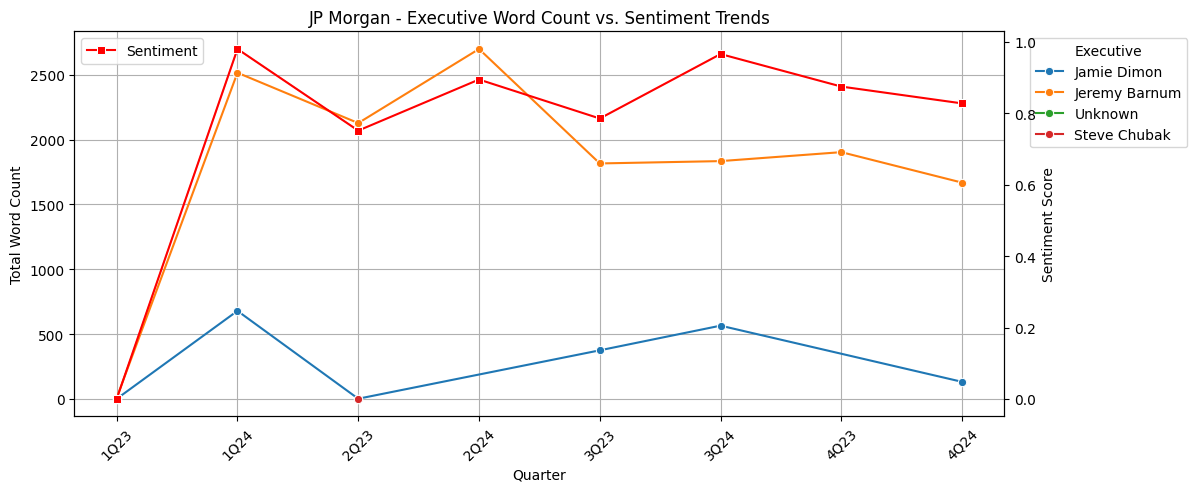

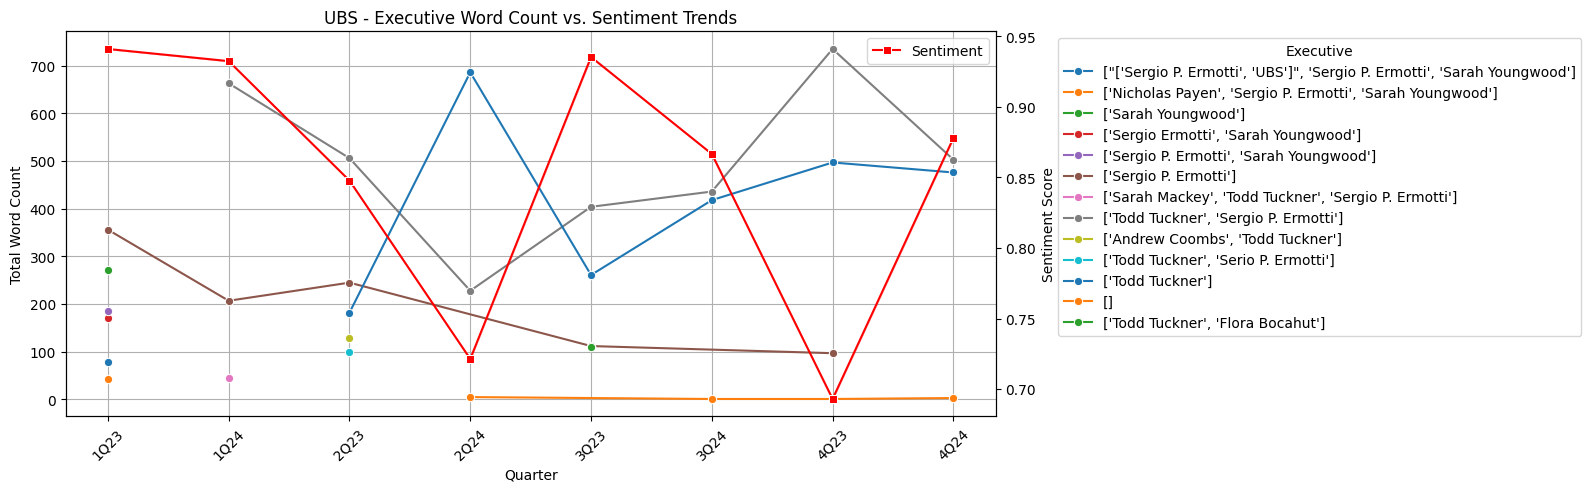

In [14]:
# Cross check executive contributions with sentiment, Q&A length, and quarterly fluctuations

jp_qna_df = pd.read_csv(f"{BOE_path}/jp_morgan_qna.csv")
jp_management_df = pd.read_csv(f"{BOE_path}/jpmorgan_management_discussion.csv")
ubs_qna_df = pd.read_csv(f"{BOE_path}/ubs_qa_df_preprocessed_ver2.csv")
ubs_management_df = pd.read_csv(f"{BOE_path}/ubs_management_discussion.csv")

sia = SentimentIntensityAnalyzer()

# compute sentiment scores if not already present
for df, question_col, answer_col in [(jp_qna_df, "Question_cleaned", "Response_cleaned"),
                                      (ubs_qna_df, "Question_cleaned", "Response_cleaned")]:
    if "question_sentiment" not in df.columns:
        df["question_sentiment"] = df[question_col].astype(str).apply(lambda x: sia.polarity_scores(x)["compound"])
    if "answer_sentiment" not in df.columns:
        df["answer_sentiment"] = df[answer_col].astype(str).apply(lambda x: sia.polarity_scores(x)["compound"])

# compute word counts
for df, answer_col in [(jp_qna_df, "Response_cleaned"), (ubs_qna_df, "Response_cleaned")]:
    df["answer_word_count"] = df[answer_col].astype(str).apply(lambda x: len(x.split()))

# aggregate sentiment per quarter
jp_sentiment_by_quarter = jp_qna_df.groupby("Quarter")[["question_sentiment", "answer_sentiment"]].mean().reset_index()
ubs_sentiment_by_quarter = ubs_qna_df.groupby("Quarter")[["question_sentiment", "answer_sentiment"]].mean().reset_index()

# compute total executive word count per quarter
jp_speaker_word_count = jp_qna_df.groupby(["Quarter", "Executive"])["answer_word_count"].sum().reset_index()
ubs_speaker_word_count = ubs_qna_df.groupby(["Quarter", "Executive"])["answer_word_count"].sum().reset_index()

# merge sentiment with executive word count
jp_merged_df = jp_speaker_word_count.merge(jp_sentiment_by_quarter, on="Quarter", how="left")
ubs_merged_df = ubs_speaker_word_count.merge(ubs_sentiment_by_quarter, on="Quarter", how="left")

# plot JP Morgan results
plt.figure(figsize=(12, 5))
sns.lineplot(data=jp_merged_df, x="Quarter", y="answer_word_count", hue="Executive", marker="o", palette="tab10")
plt.xlabel("Quarter")
plt.ylabel("Total Word Count")
plt.title("JP Morgan - Executive Word Count vs. Sentiment Trends")
plt.xticks(rotation=45)
plt.grid()

# move executive legend outside
plt.legend(title="Executive", bbox_to_anchor=(1.02, 1), loc="upper left")

ax2 = plt.gca().twinx()
sns.lineplot(data=jp_merged_df, x="Quarter", y="answer_sentiment", color="red", marker="s", label="Sentiment", ax=ax2)
ax2.set_ylabel("Sentiment Score")
ax2.legend(loc="upper left")

plt.show()

# plot UBS results
plt.figure(figsize=(12, 5))
sns.lineplot(data=ubs_merged_df, x="Quarter", y="answer_word_count", hue="Executive", marker="o", palette="tab10")
plt.xlabel("Quarter")
plt.ylabel("Total Word Count")
plt.title("UBS - Executive Word Count vs. Sentiment Trends")
plt.xticks(rotation=45)
plt.grid()
plt.legend(title="Executive", bbox_to_anchor=(1.06, 1), loc="upper left")

ax2 = plt.gca().twinx()
sns.lineplot(data=ubs_merged_df, x="Quarter", y="answer_sentiment", color="red", marker="s", label="Sentiment", ax=ax2)
ax2.set_ylabel("Sentiment Score")
ax2.legend(loc="upper right")

plt.show()

- **JPM Executives speak more when sentiment is high** (positive correlation between sentiment scores and executive word count in most quarters, peaks in sentiment coincide with high executive word counts, suggesting confidence-driven discussions in stronger financial periods - however there are cases where lower sentiment results in higher speech volume (e.g., **2Q24** CFO peak - sentiment dips, but executive word count peaks (suggesting more defensive communication))
- **JPM CFO dominates the discussion**, especially when sentiment is low, possibly responding to financial concerns. **CEO** speech varies - he is more vocal in high-sentiment quarters but **less active in defensive discussions.**


* UBS exhibits **greater volatility in both sentiment and word count** compared to JP Morgan, with notable dips in 2Q24 and 4Q23 when sentiment is lowest (and those periods also see an increase in word count - a similar pattern to JPM).
* Sergio Ermotti and Todd Tuckner dominate the discussions, with their word count trends aligning somewhat with sentiment shifts, though the pattern is less clear than at JP Morgan.
* Interestingly, UBS sentiment appears more decoupled from executive word count, suggesting other factors (e.g., market conditions or external events) may drive sentiment more than engagement levels.

💡 **Overall a certain pattern is particularly evident in UBS, where CFO contributions increase when sentiment declines, suggesting that CFOs may step in more to address concerns or provide financial justifications during uncertain periods. CFOs play a more defensive role, elaborating more when sentiment is low, particularly at UBS, where their influence appears stronger.**
